<a href="https://colab.research.google.com/github/amalvarezme/AnaliticaDatos/blob/master/6_NN_DeepLearning/Introduction_Recurrent_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Procesamiento de secuencias con redes neuronales recurrentes

Primero configuramos la sesión de trabajo

In [1]:
#-------------------------------------------------------------------------------
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)
#-------------------------------------------------------------------------------
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
#-------------------------------------------------------------------------------
# TensorFlow ≥2.0-preview is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
#-------------------------------------------------------------------------------
# Common imports
import numpy as np
import os
#-------------------------------------------------------------------------------
# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)
#-------------------------------------------------------------------------------
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
#-------------------------------------------------------------------------------

# Recurrent Neural Network  (RNN)



*   El cerebro humanos reinicia sus pensamientos cada segundo (se cuenta con memoría).
*   Nuestros pensamientos tienen persistencia.

* Las redes neuronales tradicionales no pueden hacer esto y parece ser una deficiencia importante. 

* **Por ejemplo**: imagine que quiere clasificar el tipo de evento que ocurre en cada punto de una película. No está claro cómo una red neuronal tradicional podría usar su razonamiento sobre eventos anteriores en la película para informar sobre eventos posteriores.

* Las **redes neuronales recurrentes** (Recurrent Neural Networks - RNN) abordan este problema. Son redes con bucles que permiten que la información persista.

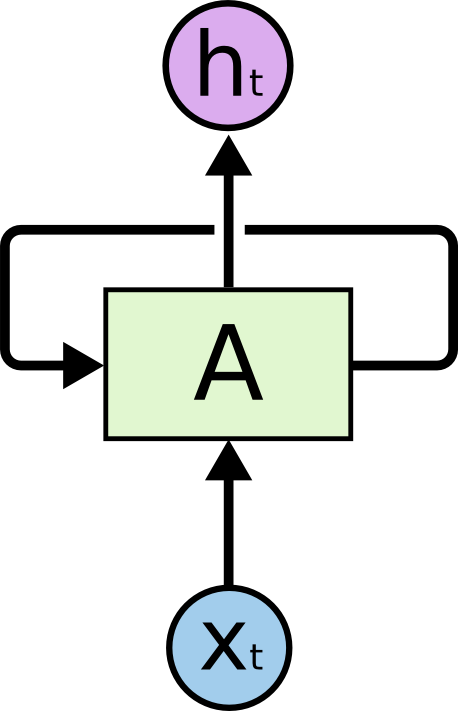

* En el diagrama anterior, una parte de la red neuronal, $A$, observa alguna entrada $x_t$ y genera un valor $h_t$. 

* Un bucle permite que la información pase de una etapa de la red a la siguiente.

* Una RNN se puede considerar como múltiples copias de la misma red, cada una de las cuales pasa un mensaje a un sucesor. 

* Si se desenrolla el ciclo sobre el bucle:

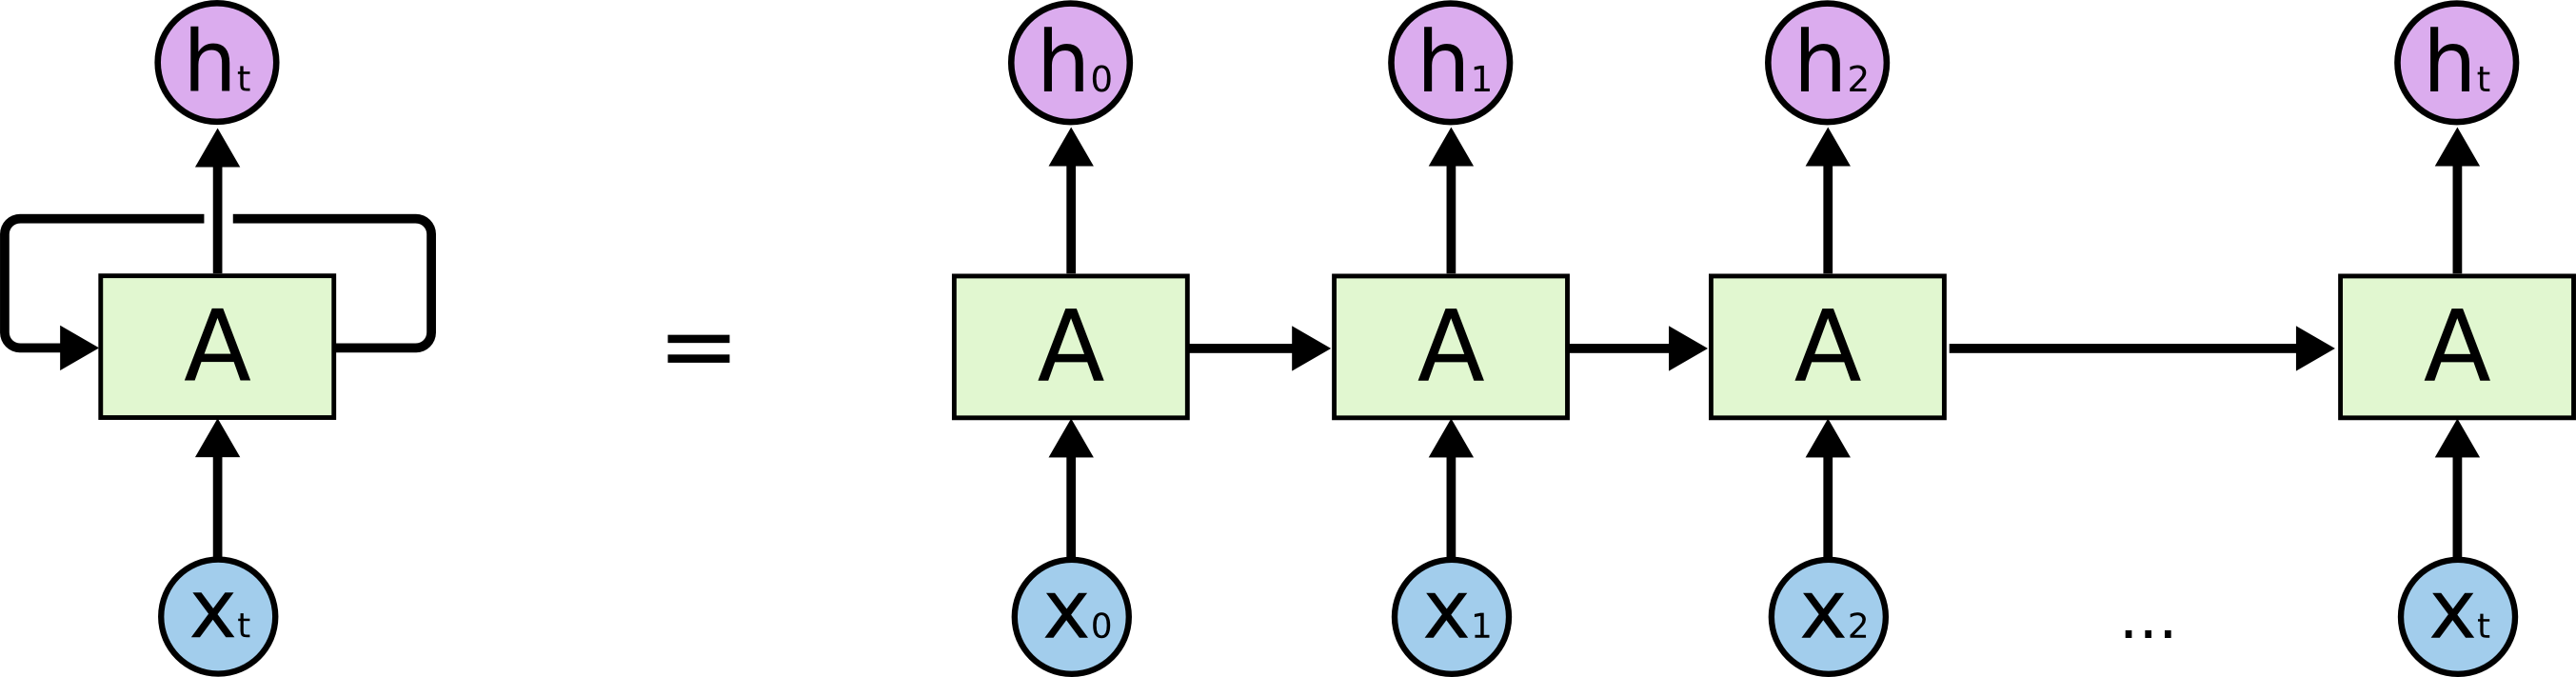

* Esta naturaleza en cadena revela que las RNN están relacionadas con secuencias y listas. 

* Las RNN son el tipo de arquitectura natural para este tipo de datos.

- ¡Y ciertamente se usan! En los últimos años, ha habido un éxito increíble en la aplicación de RNN a una variedad de problemas: reconocimiento de voz, modelado de lenguaje, traducción, subtítulos de imágenes ...

[Descripción matemática de RNNs](https://d2l.ai/chapter_recurrent-neural-networks/rnn.html)

[Algunos conceptos claves e implementación usando Keras + tensorflow](https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781788629416/1/ch01lvl1sec09/recurrent-neural-networks-rnns)

# Ejemplo:
Generamos el conjunto de series de tiempo a analizar

In [2]:
#-------------------------------------------------------------------------------
# definimos función para generar señales 1D-------------------------------------
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time   = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)
#-------------------------------------------------------------------------------

In [3]:
#-------------------------------------------------------------------------------
# definimos número de steps y batch_size----------------------------------------
n_steps    = 50
batch_size = 10000
#-------------------------------------------------------------------------------
series           = generate_time_series(batch_size, n_steps + 1)
print('Series dimension:',series.shape)
#-------------------------------------------------------------------------------
# partimos en conjuntos de train/valid/test-------------------------------------
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]
#-------------------------------------------------------------------------------
print('Train dimensions:',X_train.shape, y_train.shape)
print('Valid dimensions:',X_valid.shape, y_valid.shape)
print('Test dimensions:',X_test.shape, y_test.shape)
#-------------------------------------------------------------------------------

Series dimension: (10000, 51, 1)
Train dimensions: (7000, 50, 1) (7000, 1)
Valid dimensions: (2000, 50, 1) (2000, 1)
Test dimensions: (1000, 50, 1) (1000, 1)


In [4]:
#-------------------------------------------------------------------------------
y_train # vector de salida
#-------------------------------------------------------------------------------

array([[-0.35489398],
       [ 0.11629631],
       [-0.35395944],
       ...,
       [ 0.04946356],
       [-0.26231018],
       [ 0.60062087]], dtype=float32)

Generamos la gráfica de las series de tiempo creadas

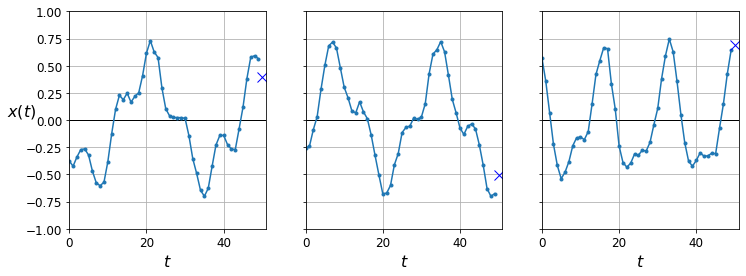

In [5]:
#-------------------------------------------------------------------------------
# definimos función para graficar las series------------------------------------
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
#-------------------------------------------------------------------------------
# graficamos 3 series del set validation----------------------------------------
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))
plt.show()
#-------------------------------------------------------------------------------

# Predicción ingenua (solo predecir el último valor):

In [6]:
#-------------------------------------------------------------------------------
# asumimos que el valor ha estimar es el último elemento de la serie----------------
y_pred = X_valid[:, -1]
#-------------------------------------------------------------------------------
# calculamos el MSE entre el y_valid vs. y_pred---------------------------------
print('MSE:',np.mean(keras.losses.mean_squared_error(y_valid, y_pred))*100,'%')
#-------------------------------------------------------------------------------

MSE: 2.0211366936564445 %


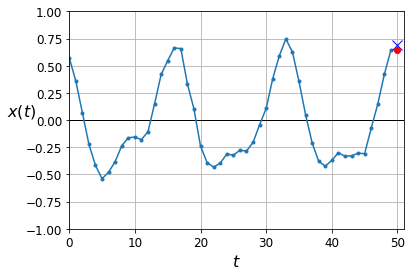

In [7]:
#-------------------------------------------------------------------------------
# graficamos valor estimado----------------------------------------------------
plot_series(X_valid[2, :, 0], y_valid[2, 0], y_pred[2, 0])
plt.show()
#-------------------------------------------------------------------------------

# Predicción lineal

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


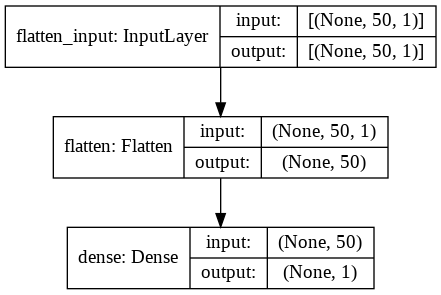

In [8]:
#-------------------------------------------------------------------------------
# definimos un modelo secuencial------------------------------------------------
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])
#-------------------------------------------------------------------------------
model.summary()
#-------------------------------------------------------------------------------
keras.utils.plot_model(model, "my_model_series.png", show_shapes=True)
#-------------------------------------------------------------------------------

Compilamos y ajustamos el modelos a los datos de train y validation

In [9]:
#-------------------------------------------------------------------------------
model.compile(loss="mse", optimizer="adam")
#-------------------------------------------------------------------------------
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
#-------------------------------------------------------------------------------

Epoch 1/20
219/219 [==============================] - 3s 3ms/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0061 - val_loss: 0.0062

In [10]:
#-------------------------------------------------------------------------------
# verificamos validación del modelo---------------------------------------------
model.evaluate(X_valid, y_valid)
#-------------------------------------------------------------------------------

63/63 [==============================] - 0s 2ms/step - loss: 0.0042


0.004168086219578981

Graficamos el desempeño del modelo secuencial

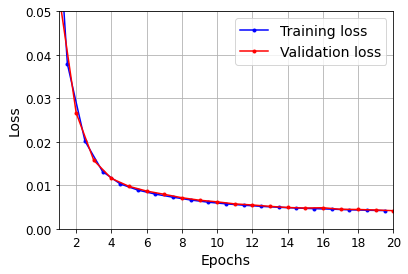

In [11]:
#-------------------------------------------------------------------------------
# definimos una función para plot de curvas de aprendizaje----------------------
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
#-------------------------------------------------------------------------------
# llamamos función de plot------------------------------------------------------
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()
#-------------------------------------------------------------------------------

Evaluamos modelo con X_valid

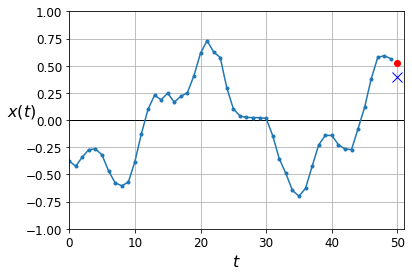

In [12]:
#-------------------------------------------------------------------------------
# hacemos predicciones de X_valid-----------------------------------------------
y_pred = model.predict(X_valid)
#-------------------------------------------------------------------------------
# pintamos series y predicciones------------------------------------------------
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()
#-------------------------------------------------------------------------------

# RNN simple
https://keras.io/api/layers/recurrent_layers/simple_rnn/

Todas las redes neuronales recurrentes tienen la forma de una cadena de módulos repetidos de red neuronal. En los RNN estándar, este módulo repetido tendrá una estructura muy simple, como una sola capa de *tanh*.
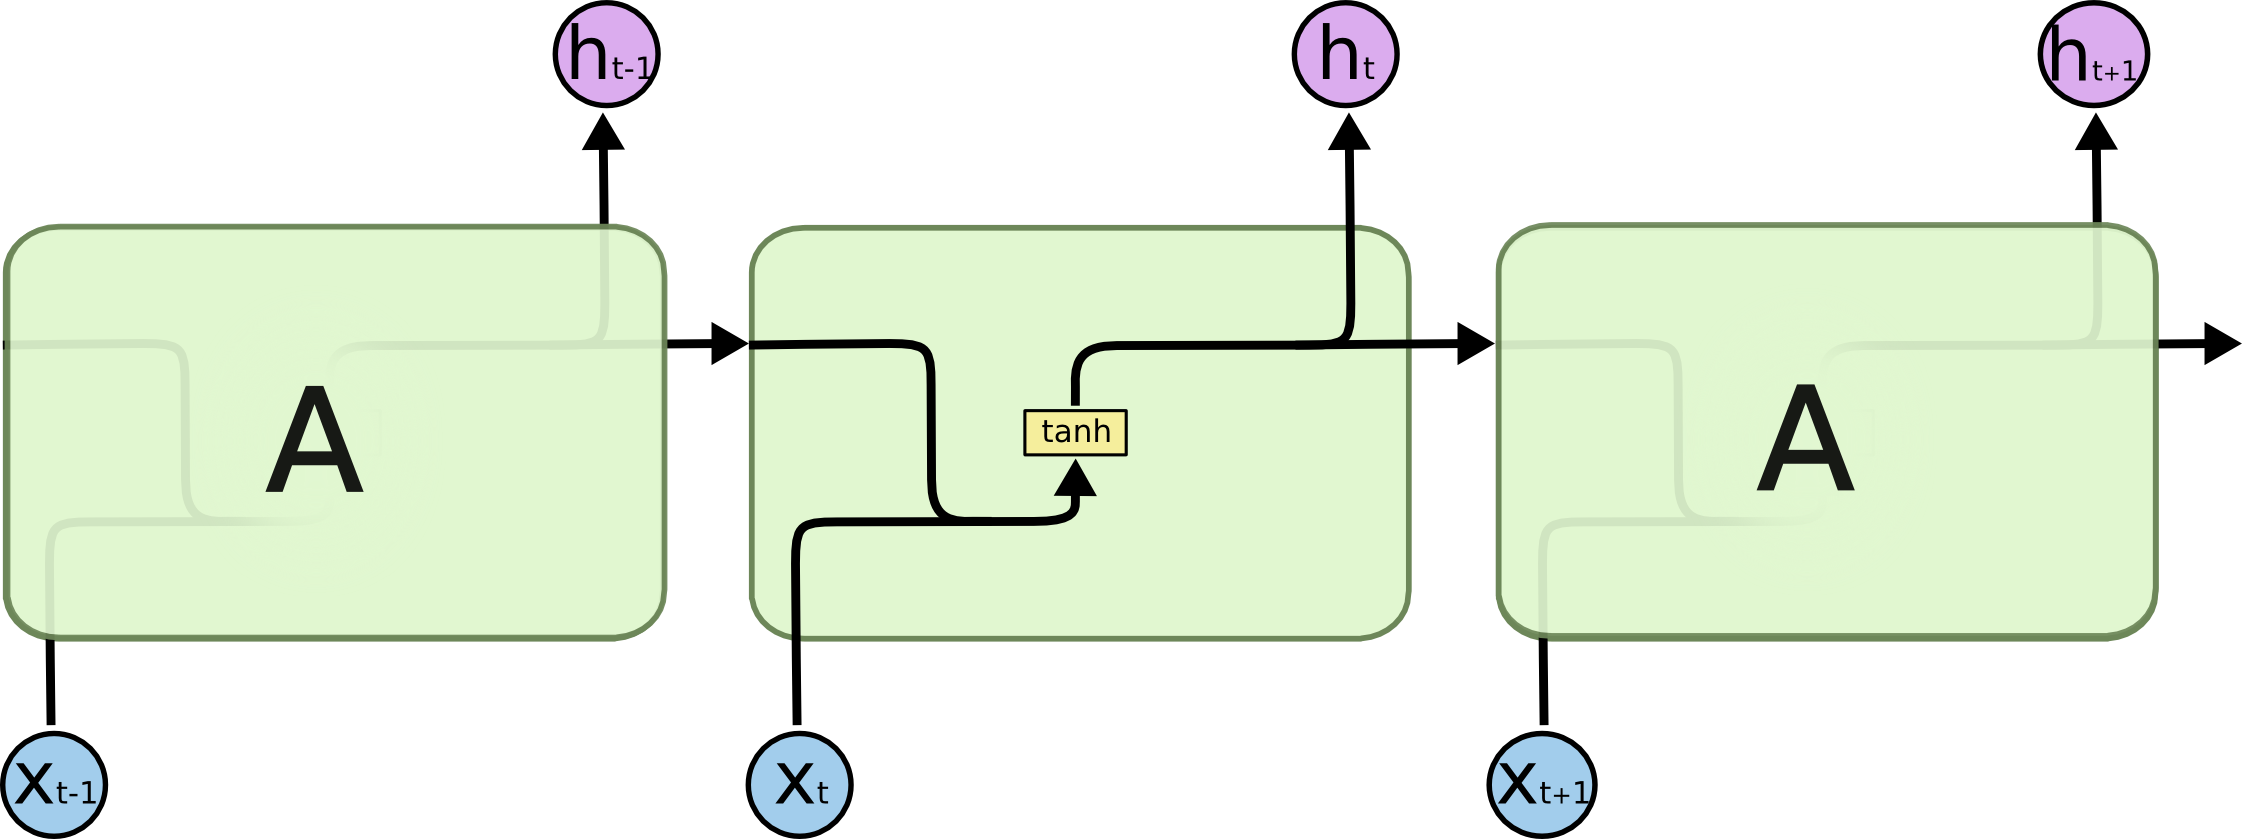

In [13]:
#-------------------------------------------------------------------------------
# definimos modelo secuencial de RNN simple-------------------------------------
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])
#-------------------------------------------------------------------------------
# compilamos el modelo RNN------------------------------------------------------
optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)
#-------------------------------------------------------------------------------
# entrenamos el modelo y lo ajustamos con los datos de valid--------------------
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
#-------------------------------------------------------------------------------

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
219/219 [==============================] - 12s 51ms/step - loss: 0.0313 - val_loss: 0.0127
Epoch 2/20
219/219 [==============================] - 11s 50ms/step - loss: 0.0119 - val_loss: 0.0112
Epoch 3/20
219/219 [==============================] - 11s 50ms/step - loss: 0.0115 - val_loss: 0.0110
Epoch 4/20
219/219 [==============================] - 11s 50ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 5/20
219/219 [==============================] - 11s 51ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 6/20
219/219 [==============================] - 11s 52ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 7/20
219/219 [==============================] - 11s 50ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 8/20
219/219 [==============================] - 11s 50ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 9/20
219/219 [==============================] - 11s 51ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 10/20
219/219 [==============================] - 11s 50ms/step - loss: 0.011

In [14]:
#-------------------------------------------------------------------------------
# verificamos performance sobre los datos de valid------------------------------
model.evaluate(X_valid, y_valid)
#-------------------------------------------------------------------------------

63/63 [==============================] - 0s 7ms/step - loss: 0.0109


0.010907161980867386

Graficamos el performance de la Simple RNN

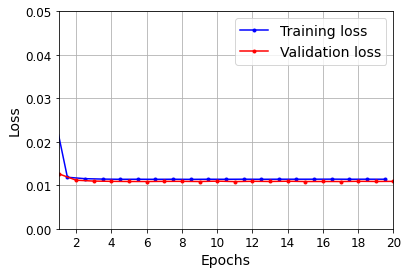

In [15]:
#-------------------------------------------------------------------------------
# graficamos curvas de aprendizaje----------------------------------------------
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()
#-------------------------------------------------------------------------------

Se analiza la predicción

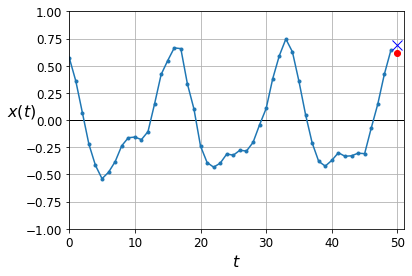

In [16]:
#-------------------------------------------------------------------------------
# evaluamos sobre set de X_valid------------------------------------------------
y_pred = model.predict(X_valid)
# pintamos la serie y la predicción---------------------------------------------
plot_series(X_valid[2, :, 0], y_valid[2, 0], y_pred[2, 0])
plt.show()
#-------------------------------------------------------------------------------

# Deep RNNs

[https://d2l.ai/chapter_recurrent-modern/deep-rnn.html](https://d2l.ai/chapter_recurrent-modern/deep-rnn.html)

In [17]:
#-------------------------------------------------------------------------------
# definimos el modelo Deep RNN como un stack de SimpleRNN-----------------------
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])
#-------------------------------------------------------------------------------
# compilamos el modelo----------------------------------------------------------
model.compile(loss="mse", optimizer="adam")
#-------------------------------------------------------------------------------
# entrenamos y ajustamos el modelo----------------------------------------------
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
#-------------------------------------------------------------------------------

Epoch 1/20
219/219 [==============================] - 39s 167ms/step - loss: 0.0175 - val_loss: 0.0051
Epoch 2/20
219/219 [==============================] - 36s 163ms/step - loss: 0.0042 - val_loss: 0.0034
Epoch 3/20
219/219 [==============================] - 36s 165ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 4/20
219/219 [==============================] - 36s 166ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 5/20
219/219 [==============================] - 36s 166ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 6/20
219/219 [==============================] - 37s 169ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 37s 168ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 8/20
219/219 [==============================] - 36s 166ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 37s 167ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 10/20
219/219 [==============================] - 36s 162ms/step - l

63/63 [==============================] - 1s 17ms/step - loss: 0.0026
0.0026385625824332237


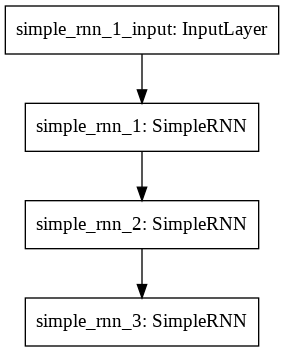

In [18]:
#-------------------------------------------------------------------------------
# verificamos evaluación del modelo---------------------------------------------
print(model.evaluate(X_valid, y_valid))
#-------------------------------------------------------------------------------
# pintamos el diagrama de bloques del modelo
tf.keras.utils.plot_model(model)
#-------------------------------------------------------------------------------

Graficamos el performance de la Deep RNN

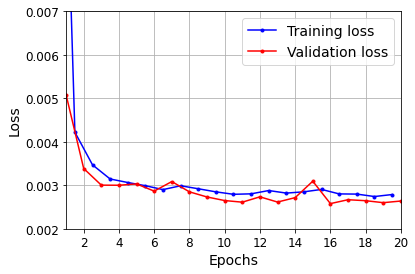

In [19]:
#-------------------------------------------------------------------------------
# graficamos curvas de aprendizaje----------------------------------------------
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.ylim(0.002,0.007)
plt.show()
#-------------------------------------------------------------------------------

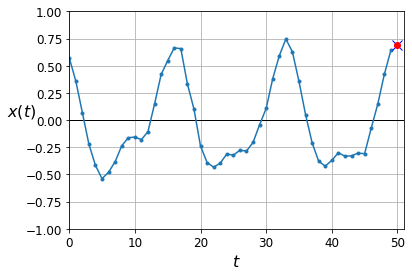

In [20]:
#-------------------------------------------------------------------------------
# evaluamos sobre set de X_valid------------------------------------------------
y_pred = model.predict(X_valid)
# pintamos la serie y la predicción---------------------------------------------
plot_series(X_valid[2, :, 0], y_valid[2, 0], y_pred[2, 0])
plt.show()
#-------------------------------------------------------------------------------

# Predicir un horizonte más lejano

In [21]:
#-------------------------------------------------------------------------------
# definimos nueva semilla aleatoria---------------------------------------------
np.random.seed(43) # not 42, as it would give the first series in the train set
#-------------------------------------------------------------------------------
# generamos nueva series de tiempo----------------------------------------------
series       = generate_time_series(1, n_steps + 10)     # horizonte de 10 valores en el tiempo
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X            = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)
#-------------------------------------------------------------------------------
Y_pred = X[:, n_steps:]
#-------------------------------------------------------------------------------

In [22]:
#-------------------------------------------------------------------------------
# observamos nuevas dimensiones de Y_pred---------------------------------------
Y_pred.shape #horizonte de 10 valores en el tiempo
#-------------------------------------------------------------------------------

(1, 10, 1)

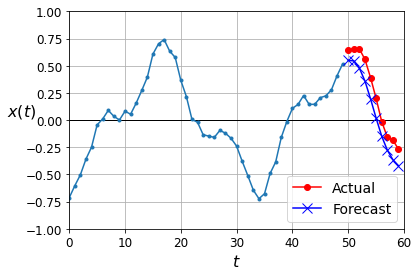

In [23]:
#-------------------------------------------------------------------------------
# definimos función para pintar forecast----------------------------------------
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)
#-------------------------------------------------------------------------------
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()
#-------------------------------------------------------------------------------

Usemos el modelo para predecir los siguientes 10 valores. Se requiere entonces generar nuevamente la secuencia con 9 pasos más en el tiempo.

In [24]:
#-------------------------------------------------------------------------------
# definimos semilla aleatoria---------------------------------------------------
np.random.seed(42)
#-------------------------------------------------------------------------------
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
print('Series dimension:',series.shape)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]
#-------------------------------------------------------------------------------
print('Train dimensions:',X_train.shape, Y_train.shape)
print('Valid dimensions:',X_valid.shape, Y_valid.shape)
print('Test dimensions:',X_test.shape, Y_test.shape)
#-------------------------------------------------------------------------------

Series dimension: (10000, 60, 1)
Train dimensions: (7000, 50, 1) (7000, 10)
Valid dimensions: (2000, 50, 1) (2000, 10)
Test dimensions: (1000, 50, 1) (1000, 10)


Predicción de los siguientes 10 valores (uno a uno y concatenar):

In [25]:
#-------------------------------------------------------------------------------
# realizamos predicción usando modelo Deep RNN----------------------------------
del X
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)
#-------------------------------------------------------------------------------
# obtenemos las predicciones de los siguientes 10 valores-----------------------
Y_pred = X[:, n_steps:, 0]
#-------------------------------------------------------------------------------
print('Y_pred dimensions:', Y_pred.shape)
#-------------------------------------------------------------------------------

Y_pred dimensions: (2000, 10)


In [26]:
#-------------------------------------------------------------------------------
# calculamos el MSE de la predicción--------------------------------------------
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))
#-------------------------------------------------------------------------------

0.022125889

Ahora se crea una RNN que permita predecir los siguientes 10 valores en una sola evaluación (predicción multi-salida):

In [27]:
#-------------------------------------------------------------------------------
# definimos semillas aleatorias-------------------------------------------------
np.random.seed(42)
tf.random.set_seed(42)
#-------------------------------------------------------------------------------
# definimos el modelo secuencial multi-salida-----------------------------------
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10) # capa densa para estimar los siguientes 10 valores
])
#-------------------------------------------------------------------------------
# compilamos el modelo----------------------------------------------------------
model.compile(loss="mse", optimizer="adam")
#-------------------------------------------------------------------------------
# entrenamos y ajustamos el modelo----------------------------------------------
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))
#-------------------------------------------------------------------------------

Epoch 1/20
219/219 [==============================] - 26s 110ms/step - loss: 0.0669 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 24s 110ms/step - loss: 0.0265 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 24s 109ms/step - loss: 0.0183 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 24s 109ms/step - loss: 0.0155 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 24s 110ms/step - loss: 0.0139 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 24s 109ms/step - loss: 0.0128 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 24s 110ms/step - loss: 0.0122 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 24s 111ms/step - loss: 0.0115 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 24s 112ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 24s 110ms/step - l

In [28]:
#-------------------------------------------------------------------------------
# generamos nuevos datos, con nueva semilla aleatoria---------------------------
np.random.seed(43)
#-------------------------------------------------------------------------------
# generamos nueva serie de tiempo-----------------------------------------------
series       = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
#-------------------------------------------------------------------------------
print('X_new dimensions:',X_new.shape)
print('Y_new dimensions:',Y_new.shape)
#-------------------------------------------------------------------------------
# hacemos predicción de los 10 últimos valores----------------------------------
Y_pred       = model.predict(X_new)[..., np.newaxis]
print('Y_pred dimensions:',Y_pred.shape)
#-------------------------------------------------------------------------------

X_new dimensions: (1, 50, 1)
Y_new dimensions: (1, 10, 1)
Y_pred dimensions: (1, 10, 1)


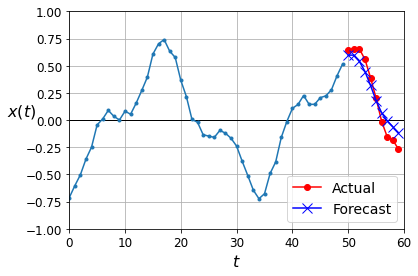

In [29]:
#-------------------------------------------------------------------------------
# graficamos el forecast--------------------------------------------------------
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()
#-------------------------------------------------------------------------------

# LSTMs: Long short term memory

[https://colah.github.io/posts/2015-08-Understanding-LSTMs/](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

## El problema de las dependencias a largo plazo:

- Uno de los atractivos de los RNN es la idea de conectar la información anterior a la tarea actual. Si los RNN pudieran hacer esto, serían extremadamente útiles. **¿Pero pueden ellos?** Depende.

- A veces, solo necesitamos mirar información reciente para realizar la tarea actual. Por **ejemplo**, considere un modelo de lenguaje que intenta predecir la siguiente palabra basándose en las anteriores. Si estamos tratando de predecir la última palabra en "*las nubes están en el cielo*", no necesitamos ningún contexto adicional; es bastante obvio que la siguiente palabra será cielo. En tales casos, donde **la brecha entre la información relevante y el lugar que se necesita es pequeña**, los RNN pueden aprender a usar la información del pasado.

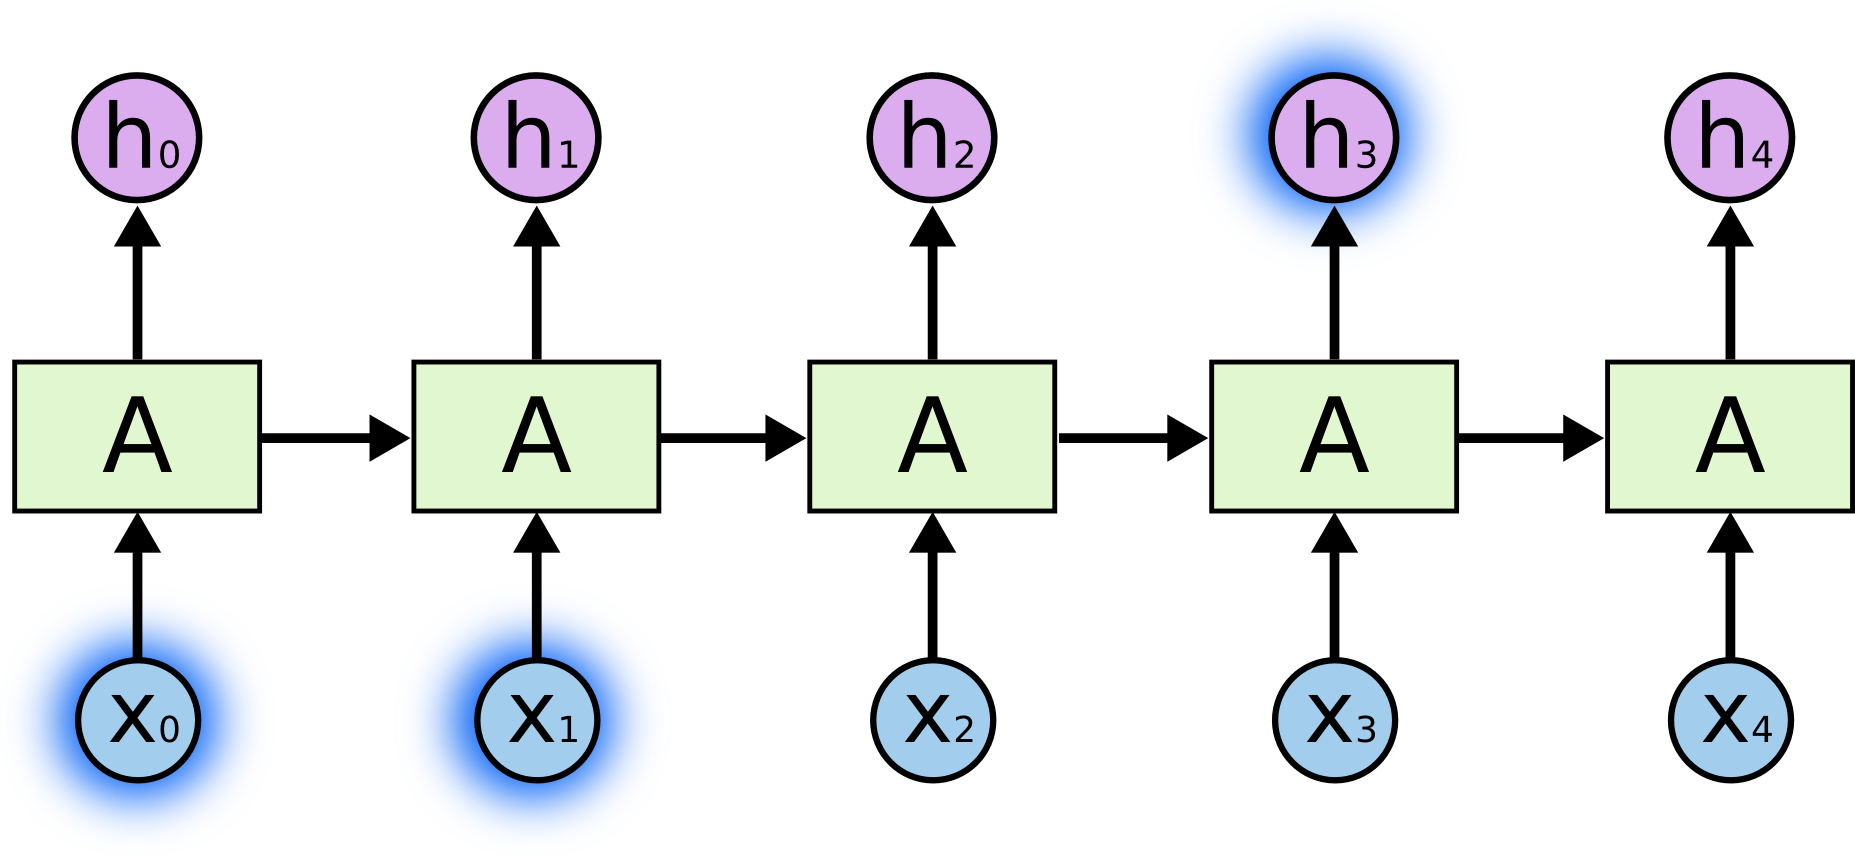

- Pero también hay casos en los que necesitamos más contexto. Considere intentar predecir la última palabra del texto "*Crecí en Francia ... hablo francés con fluidez*". La información reciente sugiere que la siguiente palabra es probablemente el nombre de un idioma, pero si queremos delimitar qué idioma, necesitamos el contexto de Francia, desde más atrás. Es totalmente posible que **la brecha entre la información relevante y el punto donde se necesita se vuelva muy grande**.

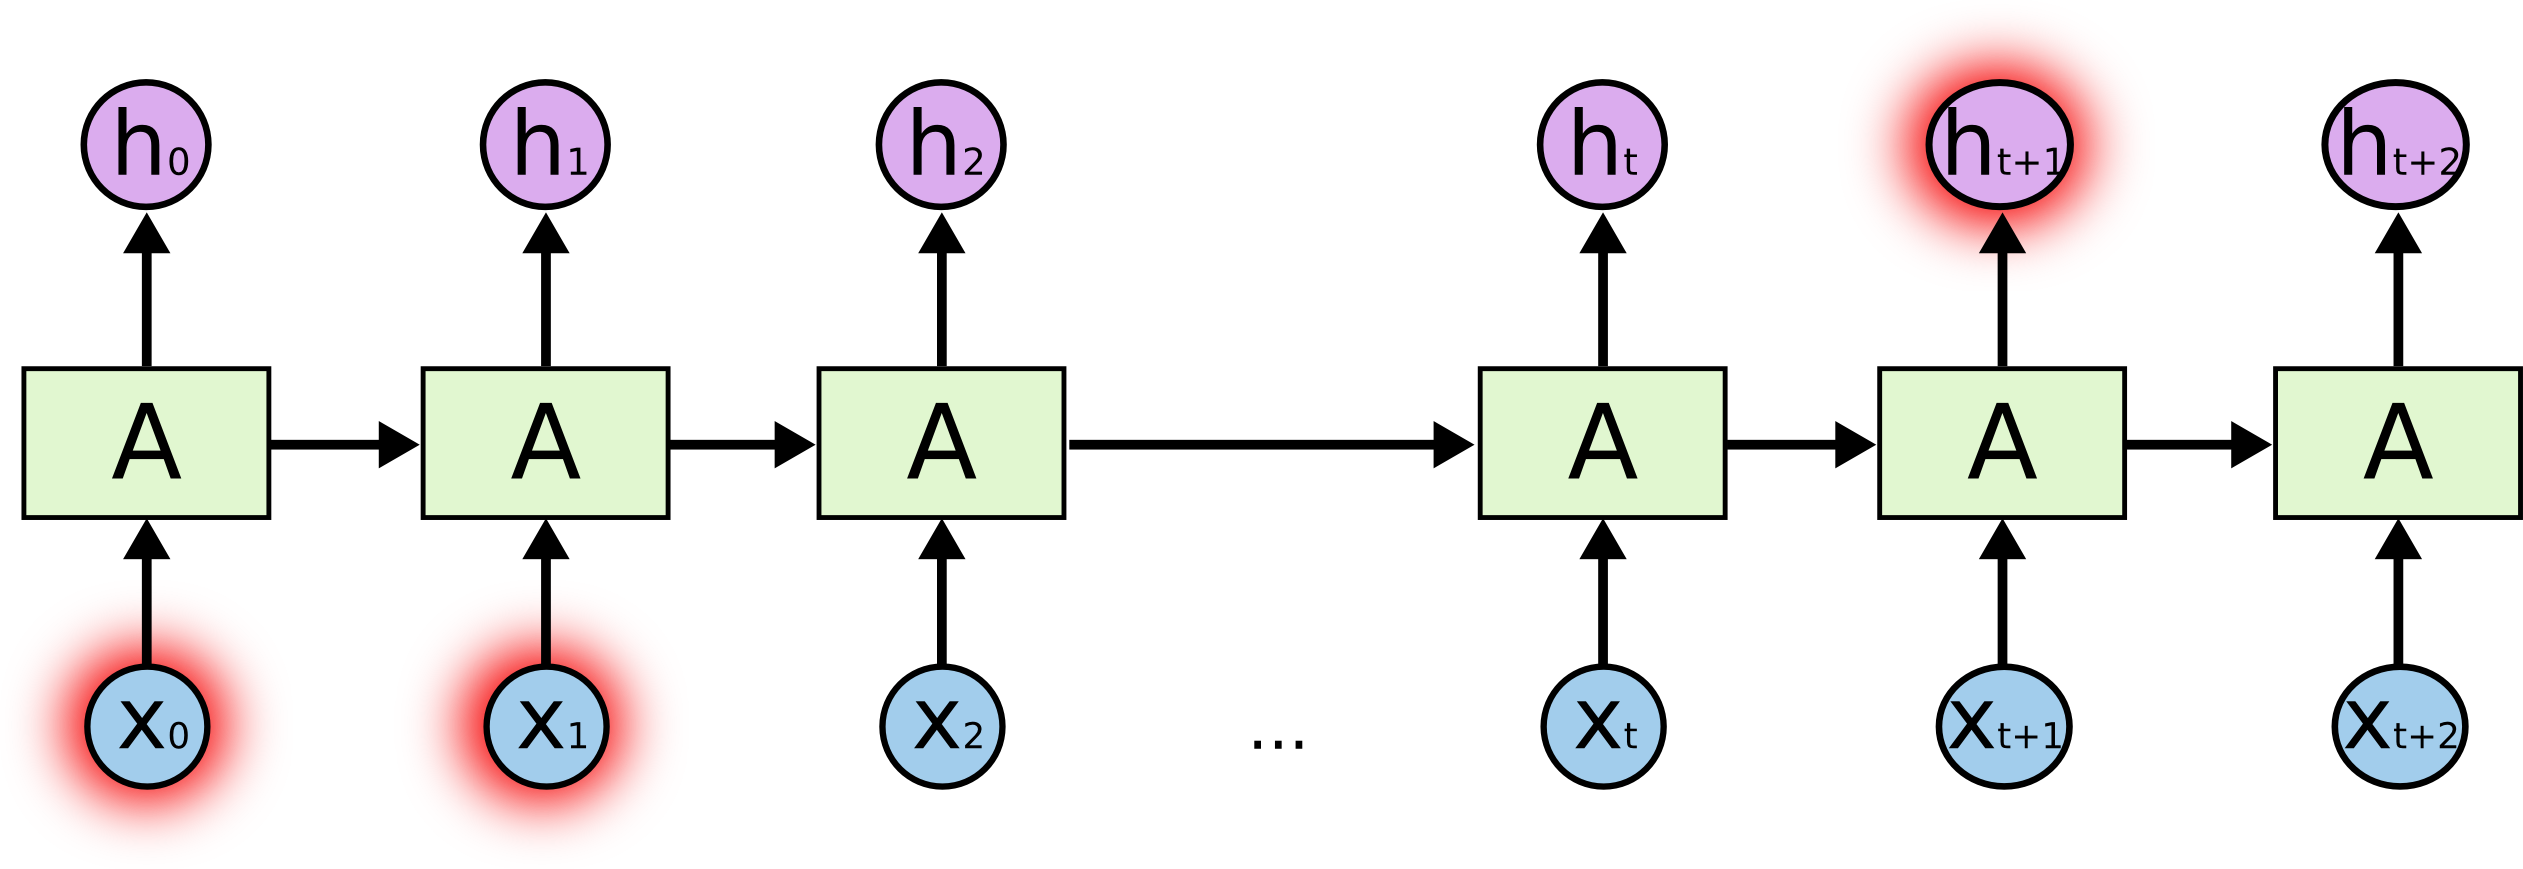

-  En teoría, los RNN son absolutamente capaces de manejar tales "dependencias a largo plazo". Lamentablemente, en la práctica, **los RNN no parecen ser capaces de aprenderlos**.


In [30]:
#-------------------------------------------------------------------------------
# generamos los datos-----------------------------------------------------------
np.random.seed(42)
#-------------------------------------------------------------------------------
# generamos series de tiempo----------------------------------------------------
n_steps = 50
series  = generate_time_series(10000, n_steps + 10)
print('Series dimensions:',series.shape)
#-------------------------------------------------------------------------------
# partimos los datos en train/valid/test----------------------------------------
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test  = series[9000:, :n_steps]
print('X_train dimensions:',X_train.shape)
print('X_valid dimensions:',X_valid.shape)
print('X_test dimensions:',X_test.shape)
#-------------------------------------------------------------------------------
# definimos nuevos Y------------------------------------------------------------
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
print('Y dimensions:',Y.shape)
#-------------------------------------------------------------------------------
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test  = Y[9000:]
#-------------------------------------------------------------------------------
print('Y_train dimensions:', Y_train.shape)
print('Y_valid dimensions:',Y_valid.shape)
print('Y_test dimensions:',Y_test.shape)
#-------------------------------------------------------------------------------

Series dimensions: (10000, 60, 1)
X_train dimensions: (7000, 50, 1)
X_valid dimensions: (2000, 50, 1)
X_test dimensions: (1000, 50, 1)
Y dimensions: (10000, 50, 10)
Y_train dimensions: (7000, 50, 10)
Y_valid dimensions: (2000, 50, 10)
Y_test dimensions: (1000, 50, 10)


In [31]:
#-------------------------------------------------------------------------------
# definimos semilla aleatoria---------------------------------------------------
np.random.seed(42)
tf.random.set_seed(42)
#-------------------------------------------------------------------------------
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])
#-------------------------------------------------------------------------------
# definimos el modelo secuencial con 2 capas LSTM-------------------------------
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])
#-------------------------------------------------------------------------------
# compilamos el modelo----------------------------------------------------------
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
#-------------------------------------------------------------------------------
# entrenamos y validamos el modelo----------------------------------------------
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))
#-------------------------------------------------------------------------------

Epoch 1/20
219/219 [==============================] - 11s 26ms/step - loss: 0.0760 - last_time_step_mse: 0.0615 - val_loss: 0.0554 - val_last_time_step_mse: 0.0364
Epoch 2/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0480 - last_time_step_mse: 0.0283 - val_loss: 0.0427 - val_last_time_step_mse: 0.0222
Epoch 3/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0391 - last_time_step_mse: 0.0181 - val_loss: 0.0367 - val_last_time_step_mse: 0.0157
Epoch 4/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0350 - last_time_step_mse: 0.0151 - val_loss: 0.0334 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0325 - last_time_step_mse: 0.0133 - val_loss: 0.0314 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0308 - last_time_step_mse: 0.0122 - val_loss: 0.0298 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/219 [=

In [32]:
#-------------------------------------------------------------------------------
# evaluamos el modelo sobre los datos de Valid----------------------------------
model.evaluate(X_valid, Y_valid)
#-------------------------------------------------------------------------------

63/63 [==============================] - 1s 9ms/step - loss: 0.0238 - last_time_step_mse: 0.0086


[0.023788688704371452, 0.008560806512832642]

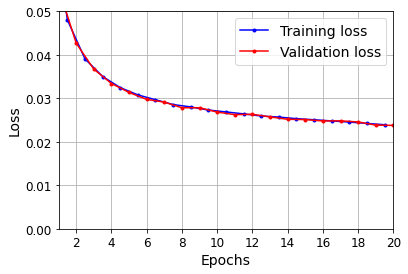

In [33]:
#-------------------------------------------------------------------------------
# observamos las curvas de aprendizaje del modelo-------------------------------
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()
#-------------------------------------------------------------------------------

In [34]:
#-------------------------------------------------------------------------------
# generamos una nueva serie de tiempo para testear el modelo--------------------
np.random.seed(43)
#-------------------------------------------------------------------------------
# generamos nueva sample--------------------------------------------------------
series       = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
#-------------------------------------------------------------------------------
# realizamos predicción---------------------------------------------------------
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]
#-------------------------------------------------------------------------------

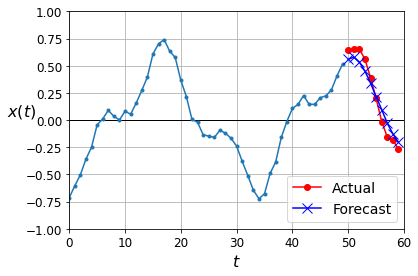

In [35]:
#-------------------------------------------------------------------------------
# graficamos el forecast--------------------------------------------------------
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()
#-------------------------------------------------------------------------------

# GRUs: Gated Recurrent Unit
[https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be](https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be)

- La GRU puede entenderse como una extensión de la capa LSTM para evitar problemas de convergencia en el gradiente.

In [36]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 9s 25ms/step - loss: 0.0738 - last_time_step_mse: 0.0655 - val_loss: 0.0538 - val_last_time_step_mse: 0.0450
Epoch 2/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0476 - last_time_step_mse: 0.0367 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0417 - last_time_step_mse: 0.0301 - val_loss: 0.0390 - val_last_time_step_mse: 0.0275
Epoch 4/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0368 - last_time_step_mse: 0.0243 - val_loss: 0.0339 - val_last_time_step_mse: 0.0202
Epoch 5/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0326 - last_time_step_mse: 0.0180 - val_loss: 0.0312 - val_last_time_step_mse: 0.0164
Epoch 6/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0306 - last_time_step_mse: 0.0155 - val_loss: 0.0294 - val_last_time_step_mse: 0.0143
Epoch 7/20
219/219 [==

In [37]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 1s 9ms/step - loss: 0.0238 - last_time_step_mse: 0.0103


[0.023785501718521118, 0.010262805968523026]

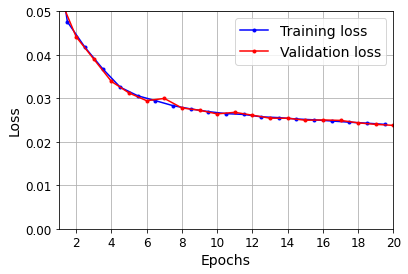

In [38]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [39]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

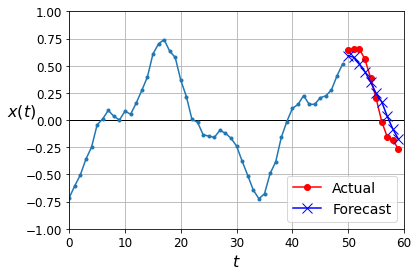

In [40]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()